# Intro

## Initial settings

In [67]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os,random, math, psutil, pickle 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import pandas as pd
import seaborn as sns
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import missingno as msno
from scipy import stats
from scipy.stats import skew
import math

sns.set()
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Import modelling libs
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from tqdm import tqdm
import lightgbm as lgb

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import backend as K
from keras.losses import mean_squared_error as mse_loss
from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

### Reducing Memory Size Function

In [2]:
## Function to reduce the DF size

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Description Table

In [3]:
path = 'C:/Users/al146/OneDrive - Heriot-Watt University/Data/Findhorn/test/'

# creats a list of all files with .csv format in above path.
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.csv' in file:
            files.append(os.path.join(r, file))

# a function for merging csv files and saving the clean result
def mergeCSV(fileslist):
    result = pd.DataFrame()
    for file in fileslist:
        table = pd.DataFrame(columns=['file_id'])
        table.loc[len(table)] = file
        filecsv = open(file)
        table['total_no'] = len(filecsv.readlines())
        df = pd.read_csv(file, names=['date', 'time', 'meter'])
        table['zero_no'] = sum((df == 0).sum(axis=1))
        table['na_no'] = sum(pd.isnull(df['meter']))
        table['zero%'] = (table['zero_no']/table['total_no'])*100
        table['na%'] = (table['na_no']/table['total_no'])*100
        result = result.append(table, ignore_index=True)
    result.file_id.replace({'C:/Users/al146/OneDrive - Heriot-Watt University/Data/Findhorn/test/':''}, regex=True, inplace=True)
    result.file_id.replace({'_15Feb2015_28Mar2015.csv':''}, regex=True, inplace=True)
    result.to_csv('csv/zero_na_no.csv')

mergeCSV(files)

zero_na_no = pd.read_csv('csv/zero_na_no.csv')
zero_na_no.drop(zero_na_no.columns[0], axis=1, inplace=True)

### Merging the input files

In [4]:
# a functon for replacing the date format of excel with python
def read_date(date):
    return xlrd.xldate.xldate_as_datetime(date, 0)

# a function for merging csv files and saving the clean result
def mergeCSV(fileslist):
    result = pd.DataFrame()
    for file in fileslist:
        table = pd.read_csv(file, names=['date', 'time', 'meter_reading'], skiprows=1)
        table["timestamp"] = table["date"] + " " + table["time"].astype(str)
        table['timestamp'] = pd.to_datetime(table['timestamp'], errors='raise', infer_datetime_format=True)
        table = table.drop(['time', 'date'], axis=1)
        table['site_id'] = file
        result = result.append(table, ignore_index=True)
    #result.site_id.replace({'_\(2015-02-15,42days\).csv':''}, regex=True, inplace=True)
    result.site_id.replace({'_15Feb2015_28Mar2015.csv':''}, regex=True, inplace=True)
    result.site_id.replace({'C:/Users/al146/OneDrive - Heriot-Watt University/Data/Findhorn/test/':''}, regex=True, inplace=True)
    #result.site_id.replace({'C:/Users/al146/Desktop/New folder/Processed-':''}, regex=True, inplace=True)
    result.site_id.replace({'D_1Ph_':''}, regex=True, inplace=True)
    result.site_id.replace({'_mf':''}, regex=True, inplace=True)
    result.to_csv('csv/merge_data.csv')
mergeCSV(files)

In [5]:
del r, f, d, file, files, path

### Creating one house data

In [6]:
data_c32 = pd.read_csv('C:/Users/al146/OneDrive - Heriot-Watt University/Data/Findhorn/test/C32_15Feb2015_28Mar2015.csv', names=['date', 'time', 'meter_reading'], skiprows=1)
data_c32["timestamp"] = data_c32["date"] + " " + data_c32["time"].astype(str)
data_c32['timestamp'] = pd.to_datetime(data_c32['timestamp'], errors='raise', infer_datetime_format=True)
data_c32 = data_c32.drop(['time', 'date'], axis=1)
data_c32['site_id'] = 'c32'
data_c32.head()

,meter_reading,timestamp,site_id
0,0.10120,2015-02-15 00:00:00,c32
1,0.06923,2015-02-15 00:05:00,c32
2,0.06946,2015-02-15 00:10:00,c32
3,0.06946,2015-02-15 00:15:00,c32
4,0.12443,2015-02-15 00:20:00,c32


### Weather data

In [7]:
weatherdata = pd.read_csv('csv/weather20092019.csv')
weatherdata.columns = weatherdata.columns.str.replace(' ', '')

In [8]:
# filitering to the station 132
weatherdata = weatherdata[weatherdata['src_id']==132]

In [9]:
drop_cols = ['Unnamed:0', 'min_grss_temp', 'min_conc_temp', 'min_grss_temp_q', 'min_conc_temp_q', 'meto_stmp_time', 'midas_stmp_etime', 'min_grss_temp_j', 'min_conc_temp_j', 'max_air_temp_q',
            'min_air_temp_q', 'max_air_temp_j', 'min_air_temp_j', 'id_type', 'id', 'ob_hour_count', 'version_num', 'met_domain_name', 'src_id', 'rec_st_ind']
weatherdata = weatherdata.drop(columns=drop_cols)

In [10]:
weatherdata['date'] = pd.to_datetime(weatherdata['ob_end_time'])

weatherdata['max_air_temp'] = pd.to_numeric(weatherdata['max_air_temp'], errors='coerce')
weatherdata['min_air_temp'] = pd.to_numeric(weatherdata['min_air_temp'], errors='coerce')

# adding a mean column
weatherdata['mean_air_temp'] = weatherdata.mean(axis=1)

In [11]:
weather_df = weatherdata[['date','max_air_temp', 'min_air_temp', 'mean_air_temp']].set_index('date').resample('D').mean().reset_index()

del weatherdata

In [12]:
weather_df.to_pickle('pkl/weather_df.pkl')
del weather_df, drop_cols
gc.collect()

22

## Loading data

### Reading and cleaning the files

In [10]:
data_df = reduce_mem_usage(pd.read_csv('csv/merge_data.csv'))
holidays_df = reduce_mem_usage(pd.read_csv('csv/UKholidays.csv'))
weather_df = reduce_mem_usage(pd.read_pickle('pkl/weather_df.pkl'))

data_df.drop(data_df.columns[0], axis=1, inplace=True)

data_df['site_id'] = data_df['site_id'].astype('str')
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], errors='raise')
holidays_df['date'] = pd.to_datetime(holidays_df['date'], errors='raise', infer_datetime_format=True)

# replace negative values with zero
data_df['meter_reading'].mask(data_df['meter_reading'] < 0, 0.09, inplace=True)
data_c32['meter_reading'].mask(data_c32['meter_reading'] < 0, 0.09, inplace=True)

Mem. usage decreased to  3.81 Mb (31.2% reduction)
Mem. usage decreased to  0.01 Mb (28.8% reduction)
Mem. usage decreased to  0.05 Mb (56.2% reduction)


### Aggregating the Data

In [14]:
data_agg_int = pd.DataFrame()
for i, id in enumerate(data_df['site_id'].value_counts().index.to_list()):
    data_agg = data_df[data_df['site_id'] == id][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').sum().reset_index()
    data_agg['site_id'] = np.str(id)
    data_agg_int = data_agg_int.append(data_agg, ignore_index=True)

data_agg = data_agg_int.copy()

In [15]:
del i, id, data_agg_int, data_agg

### Adding datetime features

In [16]:
data_df['month'] = data_df['timestamp'].dt.month.astype(np.int8)
data_df['week_of_year'] = data_df['timestamp'].dt.weekofyear.astype(np.int8)
data_df['day_of_year'] = data_df['timestamp'].dt.dayofyear.astype(np.int16)
data_df['hour_of_day'] = data_df['timestamp'].dt.hour.astype(np.int8)  
data_df['day_of_week'] = data_df['timestamp'].dt.dayofweek.astype(np.int8)
data_df['day_of_month'] = data_df['timestamp'].dt.day.astype(np.int8)
data_df['week_of_month'] = data_df['timestamp'].dt.day/7
data_df['week_of_month'] = data_df['week_of_month'].apply(lambda x: math.ceil(x)).astype(np.int8)

In [17]:
data_c32['month'] = data_c32['timestamp'].dt.month.astype(np.int8)
data_c32['week_of_year'] = data_c32['timestamp'].dt.weekofyear.astype(np.int8)
data_c32['day_of_year'] = data_c32['timestamp'].dt.dayofyear.astype(np.int16)
data_c32['hour_of_day'] = data_c32['timestamp'].dt.hour.astype(np.int8)  
data_c32['day_of_week'] = data_c32['timestamp'].dt.dayofweek.astype(np.int8)
data_c32['day_of_month'] = data_c32['timestamp'].dt.day.astype(np.int8)
data_c32['week_of_month'] = data_c32['timestamp'].dt.day/7
data_c32['week_of_month'] = data_c32['week_of_month'].apply(lambda x: math.ceil(x)).astype(np.int8)

### Convert data type

In [18]:
# list of site_ids
data_df.site_id.unique()

array(['A01', 'A03', 'A18', 'B02', 'B08', 'C02', 'C14', 'C19', 'C24',
       'C32', 'D08', 'D15', 'D20', 'D25', 'F27'], dtype=object)

In [19]:
convert_dict = {'site_id' : str,
                'month': int,
                'week_of_year': int,
                'day_of_year': int,
                'hour_of_day': int,
                'day_of_week': int,
                'day_of_month': int,
                'week_of_month': int,
                'meter_reading': float
               }

data_df = data_df.astype(convert_dict)
data_df.dtypes.value_counts()

int32             7
object            1
float64           1
datetime64[ns]    1
dtype: int64

## Data description

In [20]:
data_df.info()
holidays_df.info()
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181455 entries, 0 to 181454
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   meter_reading  181455 non-null  float64       
 1   timestamp      181455 non-null  datetime64[ns]
 2   site_id        181455 non-null  object        
 3   month          181455 non-null  int32         
 4   week_of_year   181455 non-null  int32         
 5   day_of_year    181455 non-null  int32         
 6   hour_of_day    181455 non-null  int32         
 7   day_of_week    181455 non-null  int32         
 8   day_of_month   181455 non-null  int32         
 9   week_of_month  181455 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(7), object(1)
memory usage: 9.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        -----------

In [21]:
print('Size of train_df data', data_df.shape)
print('Size of train_df data', holidays_df.shape)
print('Size of train_df data', weather_df.shape)

Size of train_df data (181455, 10)
Size of train_df data (385, 3)
Size of train_df data (3956, 4)


In [22]:
data_df.head()

,meter_reading,timestamp,site_id,month,week_of_year,day_of_year,hour_of_day,day_of_week,day_of_month,week_of_month
0,0.286621,2015-02-15 00:00:00,A01,2,7,46,0,6,15,3
1,0.286621,2015-02-15 00:05:00,A01,2,7,46,0,6,15,3
2,0.285156,2015-02-15 00:10:00,A01,2,7,46,0,6,15,3
3,0.286621,2015-02-15 00:15:00,A01,2,7,46,0,6,15,3
4,0.238770,2015-02-15 00:20:00,A01,2,7,46,0,6,15,3


In [23]:
data_df.describe()

,meter_reading,month,week_of_year,day_of_year,hour_of_day,day_of_week,day_of_month,week_of_month
count,181455.000000,181455.000000,181455.000000,181455.000000,181455.000000,181455.000000,181455.000000,181455.000000
mean,0.488741,2.666694,10.357031,66.499463,11.499049,3.000248,16.832024,2.833182
std,0.861055,0.471396,1.743282,12.120595,6.922709,2.000109,7.734447,1.067276
min,0.000000,2.000000,7.000000,46.000000,0.000000,0.000000,1.000000,1.000000
25%,0.132202,2.000000,9.000000,56.000000,5.000000,1.000000,11.000000,2.000000
50%,0.218994,3.000000,10.000000,66.000000,11.000000,3.000000,18.000000,3.000000
75%,0.367920,3.000000,12.000000,77.000000,17.000000,5.000000,23.000000,4.000000
max,11.125000,3.000000,13.000000,87.000000,23.000000,6.000000,28.000000,4.000000


## Saving the file

In [11]:
data_df.to_pickle('pkl/data_df.pkl')
holidays_df.to_pickle('pkl/holidays_df.pkl')
data_c32.to_pickle('pkl/data_c32.pkl')

del data_df
del holidays_df
del weather_df
del data_c32

gc.collect()

58

# EDA

In [3]:
# Loading the pickle file
eda_df = pd.read_pickle('pkl/data_df.pkl')
#eda_df.drop(columns=['month', 'week_of_year', 'day_of_year', 'hour_of_day', 'day_of_week', 'day_of_month', 'week_of_month'], inplace=True)

## Plots for non-aggregated data

### Daily and hourly demand for each building

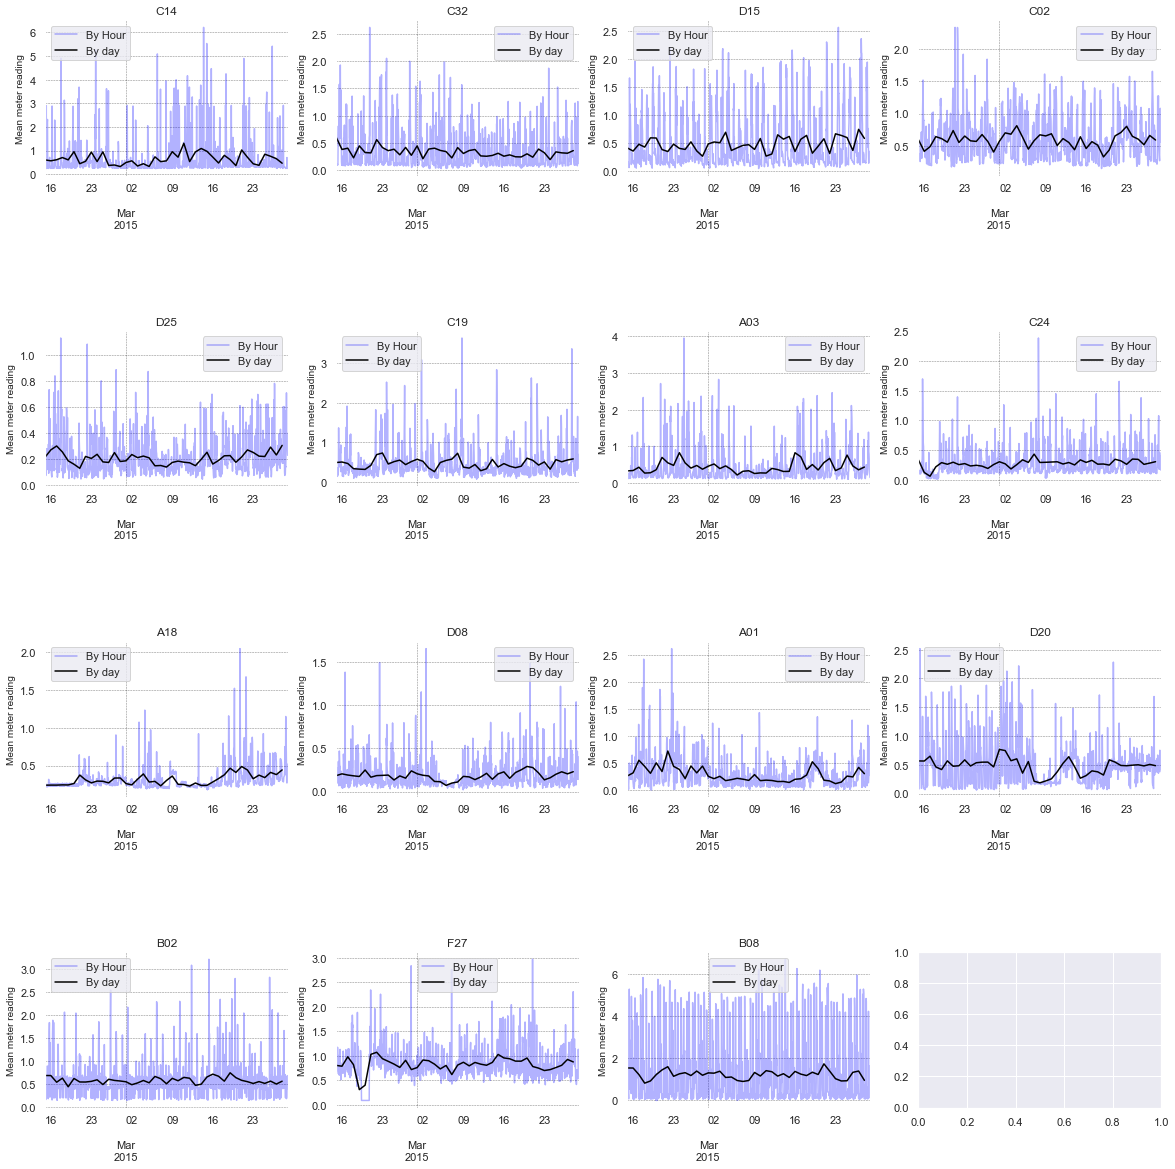

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

for i, id in enumerate(eda_df['site_id'].value_counts().index.to_list()):
    eda_df[eda_df['site_id'] == id][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%4][i//4], alpha=0.3, label='By Hour', color='blue').set_ylabel('Mean meter reading', fontsize=10);
    eda_df[eda_df['site_id'] == id][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%4][i//4], alpha=1, label='By day', color='black').set_xlabel('');
    axes[i%4][i//4].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
    axes[i%4][i//4].patch.set_facecolor('white')
    axes[i%4][i//4].legend();
    axes[i%4][i//4].set_title(id, fontsize=12);
    plt.subplots_adjust(hspace=1)

### Missing data and zeros visualized

C:\Python37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1, 'Missing data and zeros visualized')

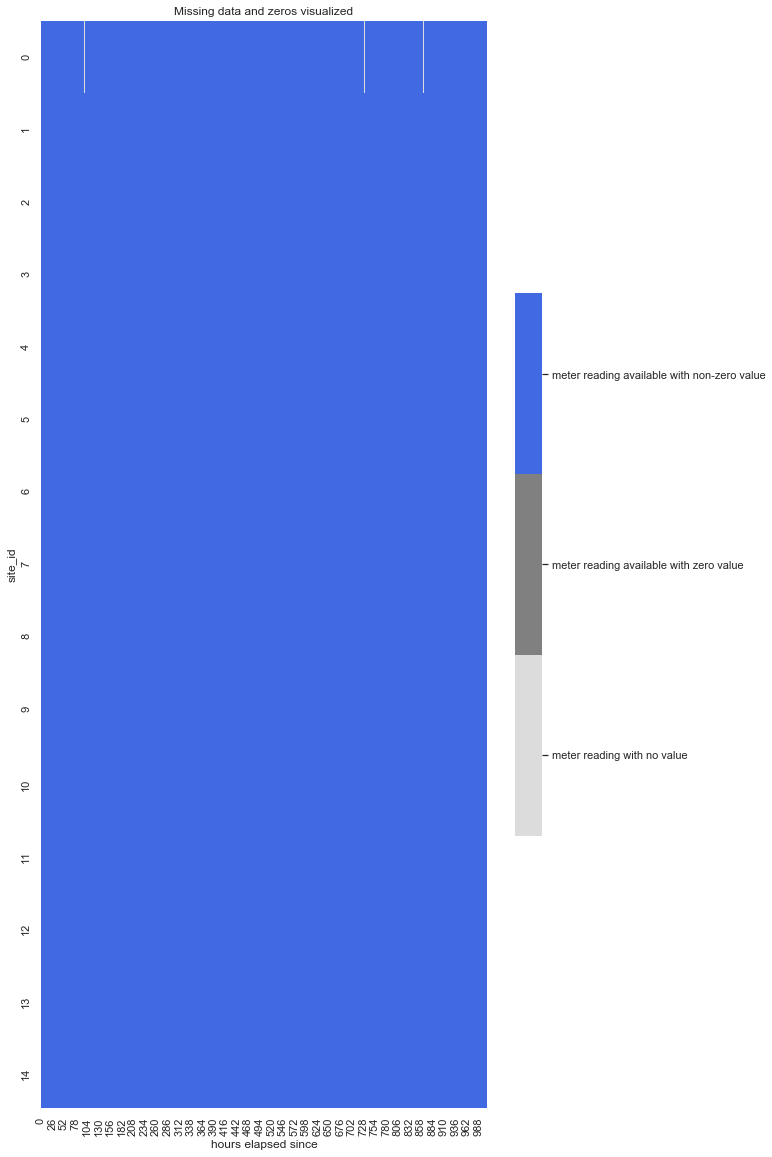

In [27]:
# Load data to another df
train_sns = eda_df.set_index(['timestamp'])

# change the site_id to numbers first
train_sns['site_id'] = train_sns.site_id.replace(['A01', 'A03', 'A18', 'B02', 'B08', 'C02', 'C14', 'C19',
       'C24', 'C32', 'D08', 'D15', 'D20', 'D25', 'F27'], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

f,ax=plt.subplots(1,1,figsize=(10,20))
df = train_sns.copy().reset_index()
df['timestamp'] = df["timestamp"].values.astype('timedelta64[ns]')
df['timestamp'] = pd.to_timedelta(df.timestamp).dt.total_seconds() / 3600
df['timestamp'] = df.timestamp.astype(int)
df.timestamp -= df.timestamp.min()

# create a new column for sites with no energy reading
df['nodata'] = 0
df.nodata[(df['meter_reading'].isnull())] = 1

# sum the meter reading for each hour
df = df.groupby(['timestamp', 'site_id']).sum()
df = df.reset_index()

missmap = np.empty((15, df.timestamp.max()+1))
missmap.fill(np.nan)
for l in df.values:
    if l[3]>=1 and l[2]==0:
        missmap[int(l[1]), int(l[0])] = 0
    elif l[2]==0:
        missmap[int(l[1]), int(l[0])] = 0.5
    else:
        missmap[int(l[1]), int(l[0])] = 1

# Define colors
from matplotlib.colors import LinearSegmentedColormap
colors = ('gainsboro', 'gray', 'royalblue')
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

sns.heatmap(missmap, cmap=cmap, ax=ax, cbar=True, cbar_kws={"shrink": .5})

# Set the colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.15, 0.5, 0.85])
colorbar.set_ticklabels(['meter reading with no value', 'meter reading available with zero value', 'meter reading available with non-zero value'])

# Set axis labels
ax.set_ylabel('site_id')    
ax.set_xlabel('hours elapsed since')
ax.set_title('Missing data and zeros visualized')

### Average meter_reading by hour

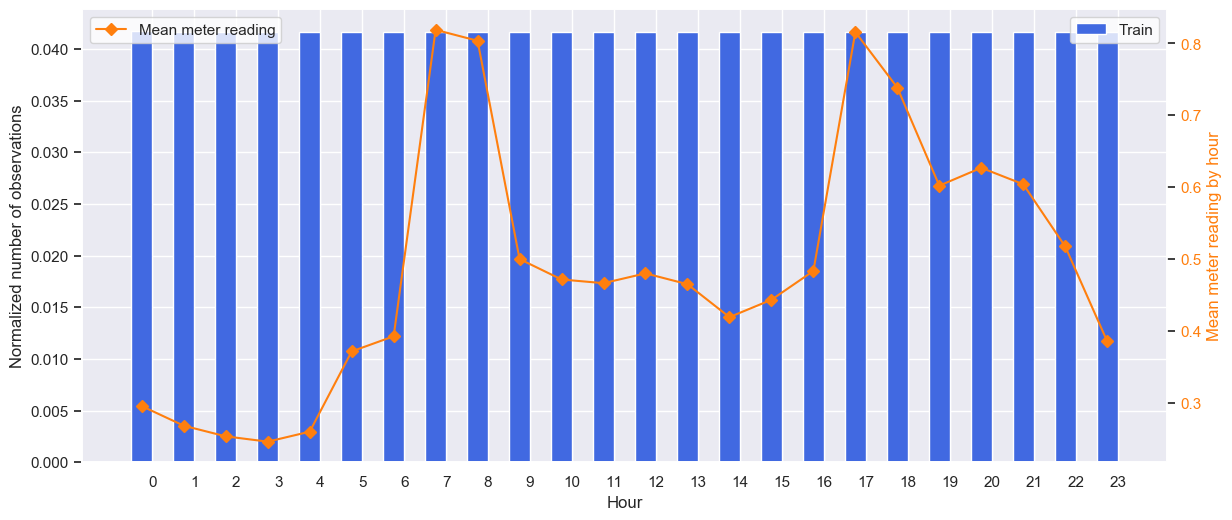

In [28]:
del train_sns

train_data = eda_df['hour_of_day'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.5

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('Hour');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(eda_df['hour_of_day'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, eda_df[['hour_of_day', 'meter_reading']].groupby('hour_of_day')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by hour', color='tab:orange');
axes.legend([tr], ['Train'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

### Average meter_reading by day

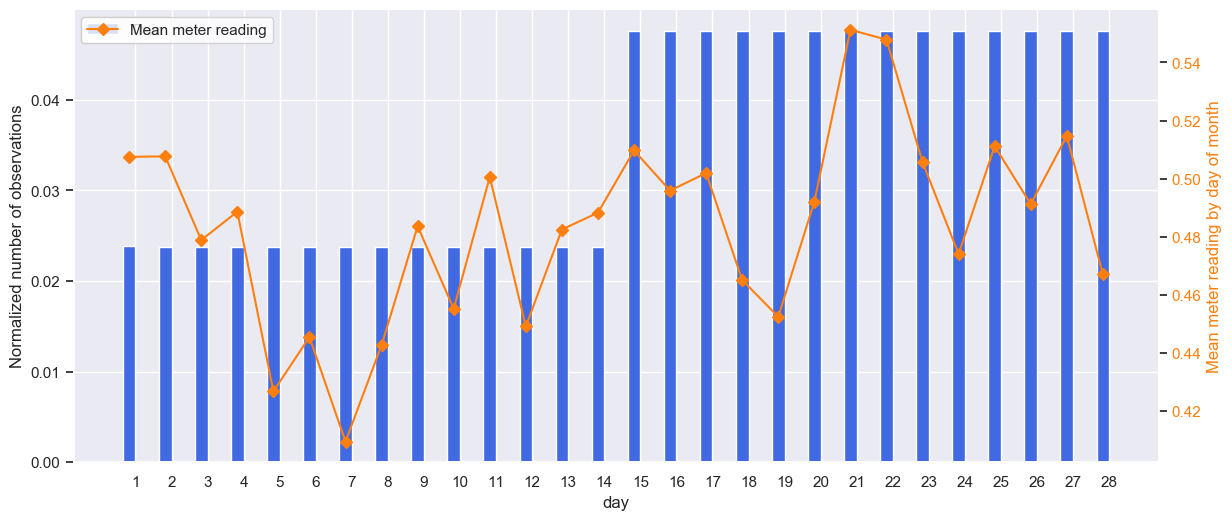

In [29]:
train_data = eda_df['day_of_month'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('day');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(eda_df['day_of_month'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, eda_df[['day_of_month', 'meter_reading']].groupby('day_of_month')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of month', color='tab:orange');
axes.legend([tr], ['Train'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

### Average meter_reading by weekday

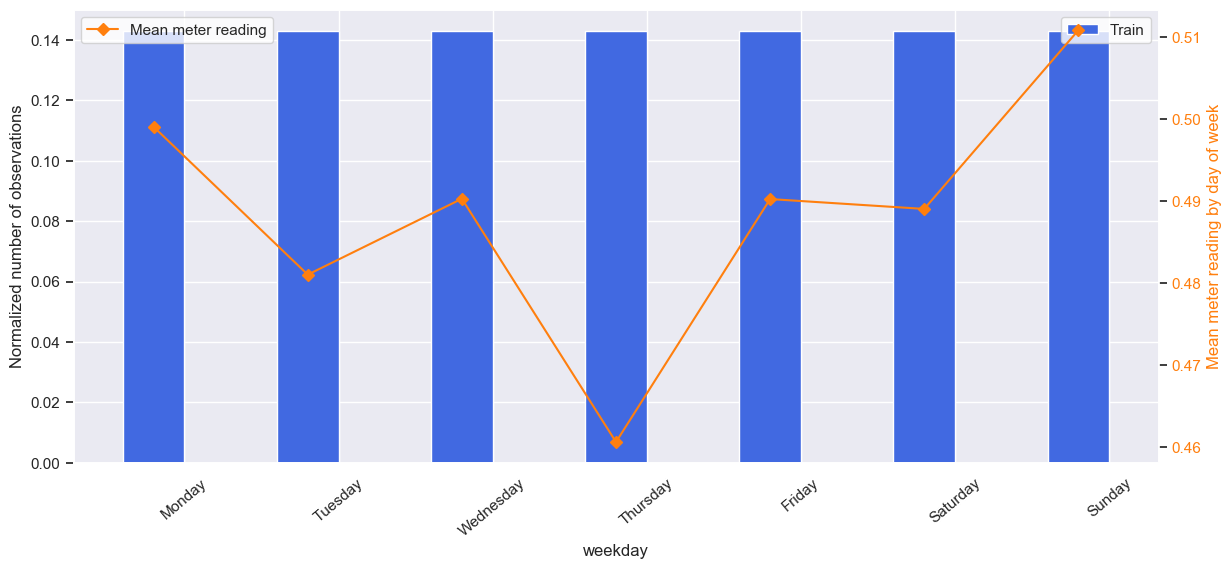

In [30]:
train_data = eda_df['day_of_week'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.4

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('weekday');
axes.set_xticks(ind + width / 2)
axes2 = axes.twinx()
mr = axes2.plot(ind, eda_df[['day_of_week', 'meter_reading']].groupby('day_of_week')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of week', color='tab:orange');
axes.legend([tr], ['Train'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

axes.set_xticklabels(eda_df['day_of_week'].value_counts().sort_index().index.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}), rotation=40);

### Average meter_reading by site_id

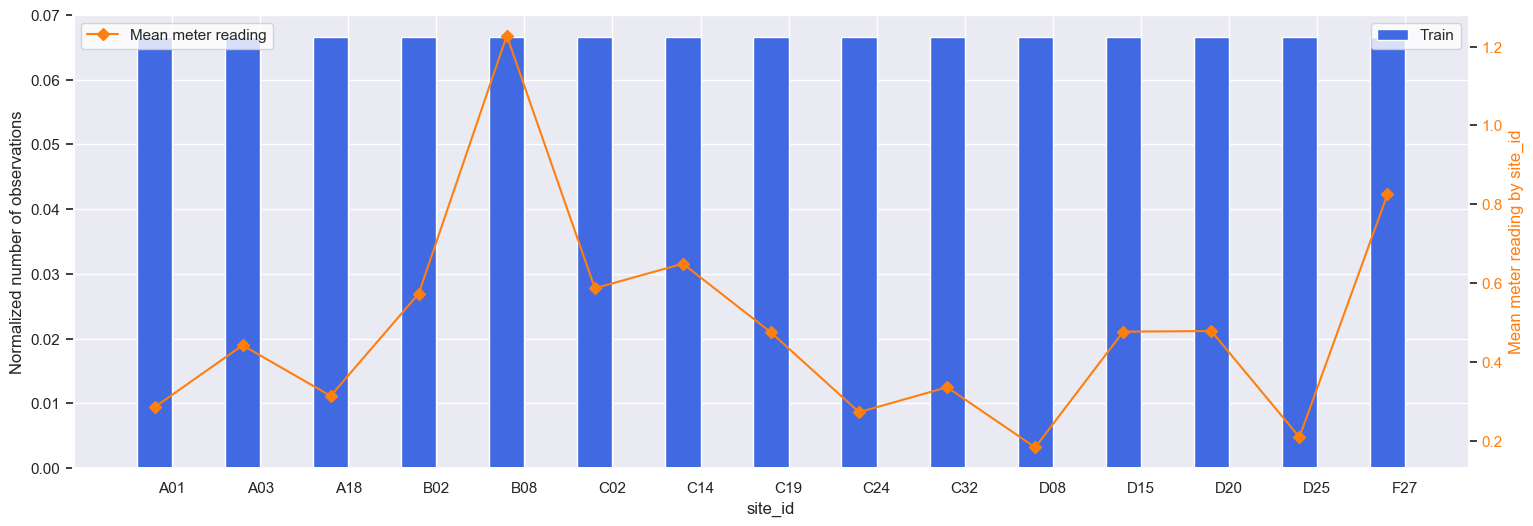

In [31]:
train_data = eda_df['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.4

fig, axes = plt.subplots(1,1,figsize=(18, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('site_id');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(eda_df['site_id'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, eda_df[['site_id', 'meter_reading']].groupby('site_id')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by site_id', color='tab:orange');
axes.legend([tr], ['Train'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

### Box plot of meter_readig by site_id

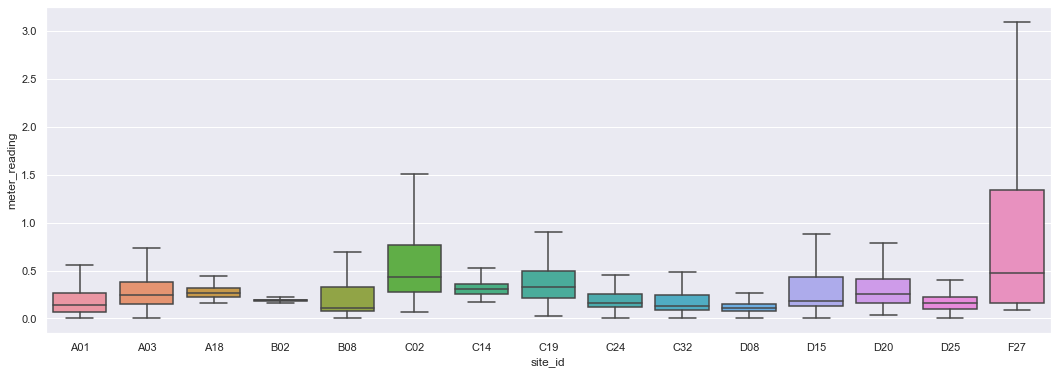

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
sns.boxplot(x='site_id', y='meter_reading', data=eda_df, showfliers=False);

### Number of observations by day

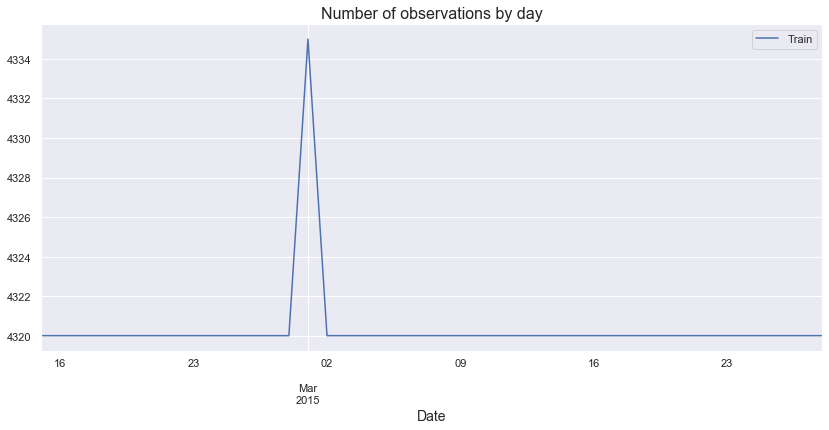

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
eda_df['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
axes.set_title('Number of observations by day', fontsize=16);
axes.legend(['Train']);

### Amount of data and NaNs

In [34]:
total = eda_df.isnull().sum().sort_values(ascending = False)
percent = (eda_df.isnull().sum()/eda_df.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data.head(10)

,Total,Percent
week_of_month,0,0.0
day_of_month,0,0.0
day_of_week,0,0.0
hour_of_day,0,0.0
day_of_year,0,0.0
week_of_year,0,0.0
month,0,0.0
site_id,0,0.0
timestamp,0,0.0
meter_reading,0,0.0


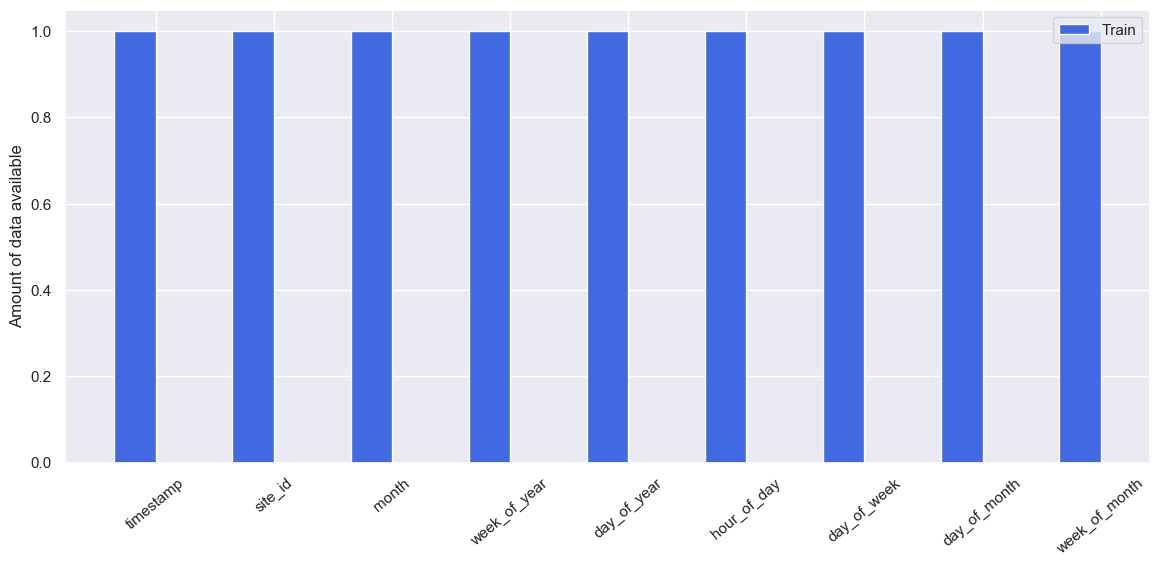

In [35]:
train_data = (eda_df.count() / len(eda_df)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((eda_df.count() / len(eda_df)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr], ['Train']);

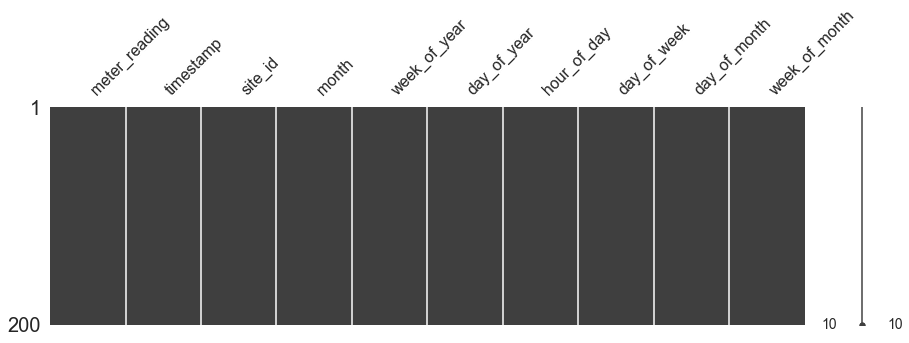

In [36]:
msno.matrix(eda_df.head(200), figsize=(15,4))

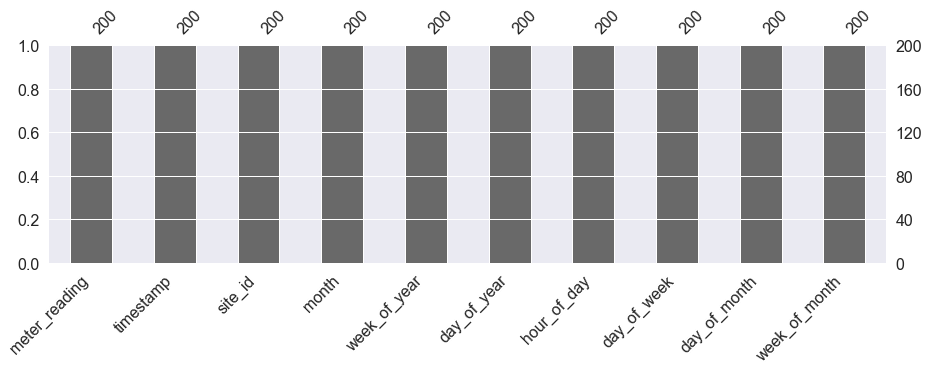

In [37]:
msno.bar(eda_df.head(200), figsize=(15,4))

C:\Python37\lib\site-packages\seaborn\matrix.py:280: UserWarning:

Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.

C:\Python37\lib\site-packages\seaborn\matrix.py:280: UserWarning:

Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.



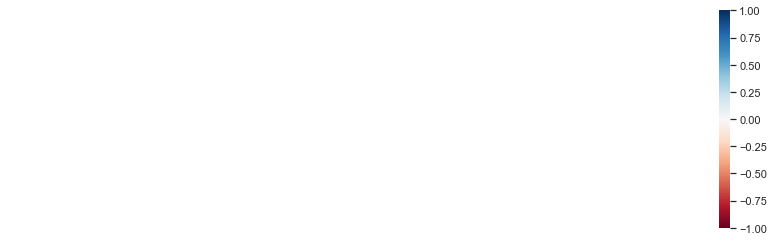

In [38]:
a = msno.heatmap(eda_df, sort='ascending', figsize=(15,4))

C:\Python37\lib\site-packages\scipy\cluster\hierarchy.py:2837: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



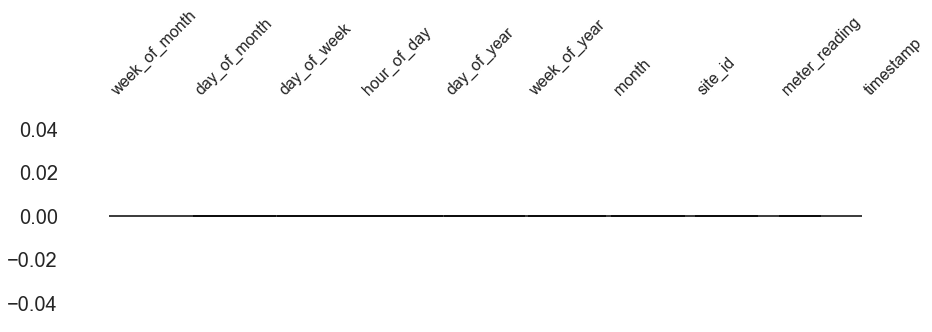

In [39]:
msno.dendrogram(eda_df, figsize=(15,4))

## Examine the Distribution of the Target Column

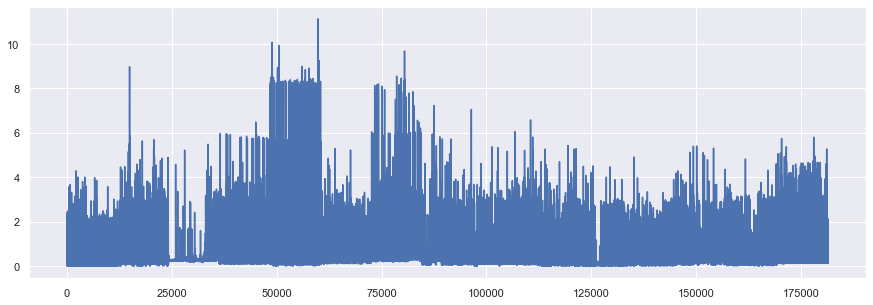

In [40]:
plt.figure(figsize = (15,5))
eda_df['meter_reading'].plot()

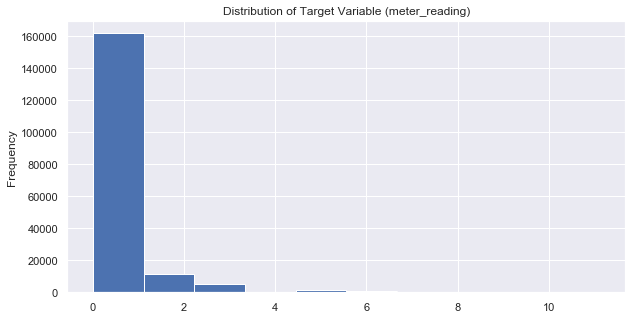

In [41]:
eda_df['meter_reading'].plot(kind='hist',
                            bins=10,
                            figsize=(10, 5),
                           title='Distribution of Target Variable (meter_reading)')
plt.show()

count    181455.000000
mean          0.488741
std           0.861055
min           0.000000
25%           0.132202
50%           0.218994
75%           0.367920
max          11.125000
Name: meter_reading, dtype: float64

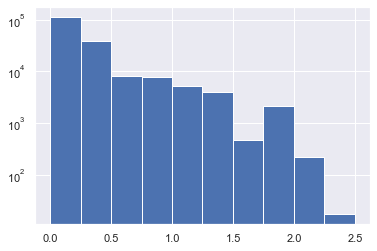

In [42]:
#Target's log-log histogram:

ax = np.log1p(eda_df['meter_reading']).hist()
ax.set_yscale('log')
eda_df.meter_reading.describe()

## Outlier analysis

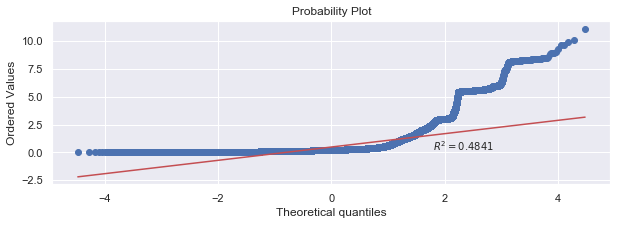

In [43]:
plt.figure(figsize=(10,3))
_ = stats.probplot(eda_df['meter_reading'], fit=True, rvalue=True, plot=plt)
#plt.title("Probability plot for meter_reading shows extreme skewness")
plt.show()

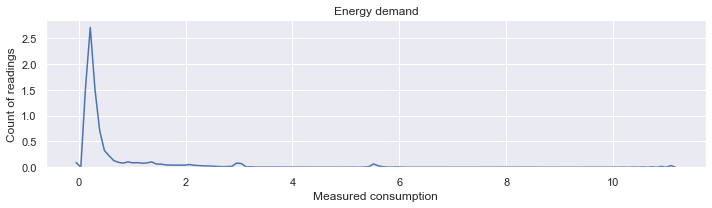

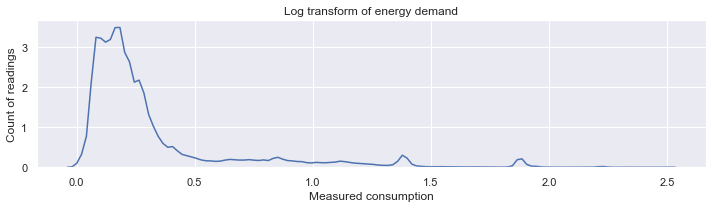

In [44]:
plt.figure(figsize=(10,3))
sns.distplot(eda_df.meter_reading, hist=False)
#plt.title(f"Target variable meter_reading is highly skewed")
plt.title("Energy demand")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
sns.distplot(np.log1p(eda_df.meter_reading), hist=False)
#plt.title(f"After log transform, distributions of energy types look comparably skewed")
plt.title("Log transform of energy demand")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.tight_layout()
plt.show()

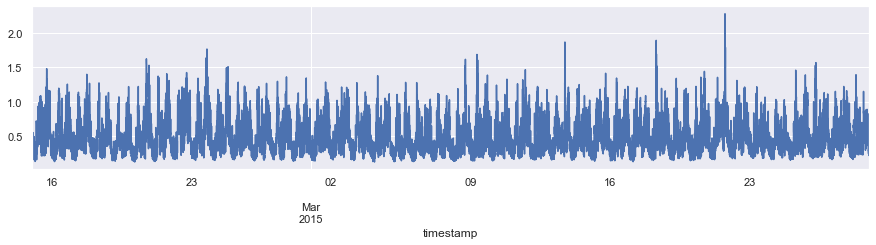

In [45]:
y_mean_time = eda_df.groupby('timestamp').meter_reading.mean()
y_mean_time.plot(figsize=(15, 3))

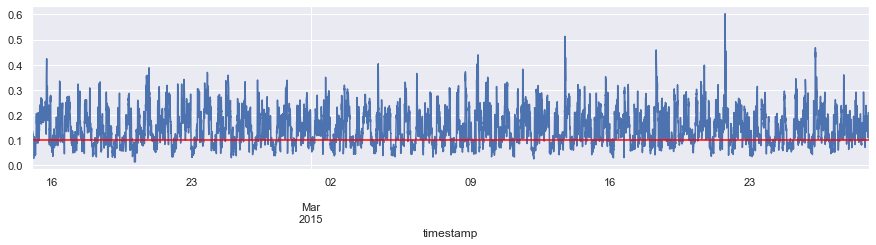

In [46]:
y_mean_time.rolling(window=10).std().plot(figsize=(15, 3))
plt.axhline(y=0.1, color='red')
plt.axvspan(0, 23, color='green', alpha=0.1)

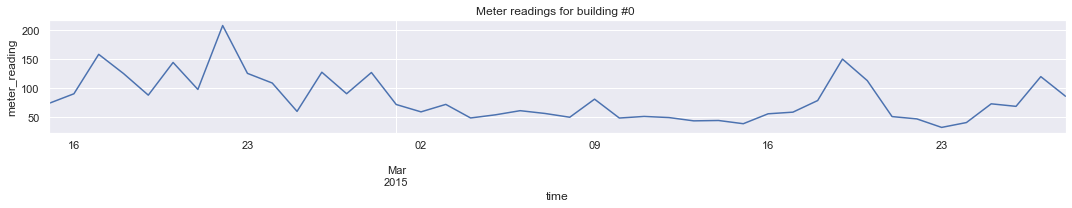

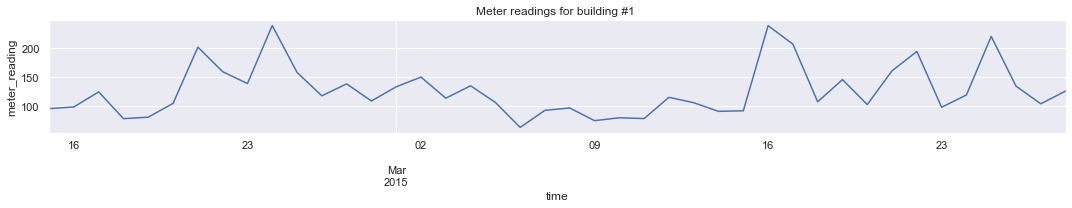

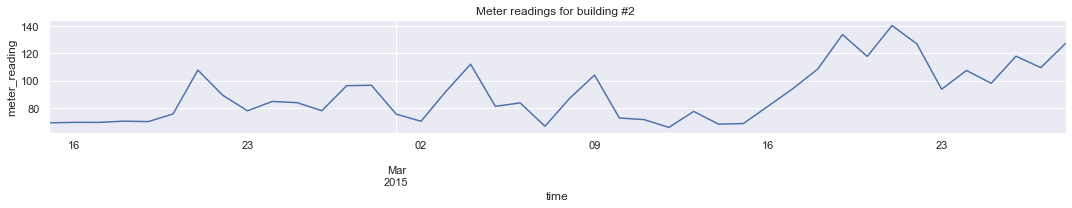

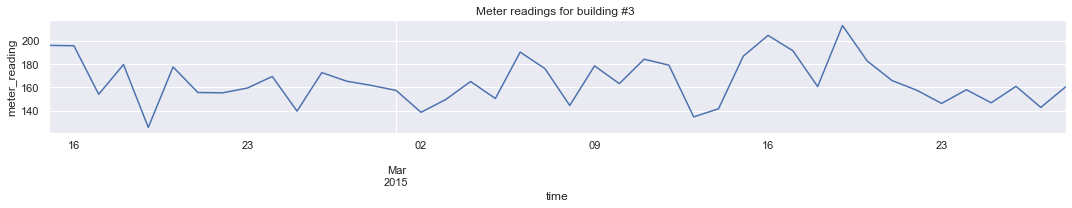

In [47]:
train_df2 = eda_df.copy()

# change the site_id to numbers first
train_df2['site_id'] = train_df2.site_id.replace(['A01', 'A03', 'A18', 'B02', 'B08', 'C02', 'C14', 'C19',
       'C24', 'C32', 'D08', 'D15', 'D20', 'D25', 'F27'], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

# for first four
for bldg_id in [0, 1, 2, 3]:
    plt.figure(figsize=(15,3))
    tmp_df = train_df2[train_df2.site_id == bldg_id].copy()
    tmp_df.set_index("timestamp", inplace=True)
    tmp_df.resample("D").meter_reading.sum().plot()
    plt.title(f"Meter readings for building #{bldg_id} ")
    plt.xlabel("time")
    plt.ylabel("meter_reading")
    plt.tight_layout()
    plt.show()

## Delete eda_df

In [48]:
del eda_df

# Modelling

## Loading data

In [175]:
data_df = reduce_mem_usage(pd.read_pickle('pkl/data_c32.pkl'))
holidays_df = reduce_mem_usage(pd.read_pickle('pkl/holidays_df.pkl'))
weather_df = reduce_mem_usage(pd.read_pickle('pkl/weather_df.pkl'))

Mem. usage decreased to  0.21 Mb (25.0% reduction)
Mem. usage decreased to  0.01 Mb (0.0% reduction)
Mem. usage decreased to  0.05 Mb (56.2% reduction)


In [140]:
# adding a data column for merging
data_df['date'] = data_df['timestamp'].dt.date.astype(np.datetime64)

data_mer = data_df.set_index('date').join(holidays_df.set_index('date'), on='date', how='left').reset_index()

data_mer.drop(labels=['name'], axis=1, inplace=True)

In [141]:
data_merge = data_mer.join(weather_df.set_index('date'), on='date', how='left').reset_index()
data_merge.drop(labels=['date', 'index'], axis=1, inplace=True)

In [142]:
# fill the holiday column na with zeros
data_merge['bank_holiday'].fillna(np.int64(0), inplace=True)
data_merge['bank_holiday'] = data_merge['bank_holiday'].astype(np.int64)

## Spliting and preparing the data

In [53]:
# change the site_id to numbers first
#data_merge['site_id'] = data_merge.site_id.replace(['A01', 'A02', 'A03', 'A18', 'B02', 'B08', 'C02', 'C14', 'C19',
#       'C24', 'C32', 'D08', 'D15', 'D20', 'D25', 'F27'], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

data_merge['site_id'] = data_merge.site_id.replace(['a01'], [1])
    
X = data_merge.values

train_size = int(len(X) * 0.8)
traindf, testdf = X[0:train_size], X[train_size:len(X)]
print('Number of Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(traindf)))
print('Testing Observations: %d' % (len(testdf)))

train_df = pd.DataFrame(traindf, columns=['meter_reading', 'time', 'site_id', 'month', 'week_of_year', 'day_of_year', 'hour_of_day', 'day_of_week', 'day_of_month', 'week_of_month', 'bank_holiday', 'max_air_temp', 'min_air_temp', 'mean_air_temp'])
test_df = pd.DataFrame(testdf, columns=['meter_reading', 'time', 'site_id', 'month', 'week_of_year', 'day_of_year', 'hour_of_day', 'day_of_week', 'day_of_month', 'week_of_month', 'bank_holiday', 'max_air_temp', 'min_air_temp', 'mean_air_temp'])
test_val = pd.DataFrame(testdf, columns=['meter_reading', 'time', 'site_id', 'month', 'week_of_year', 'day_of_year', 'hour_of_day', 'day_of_week', 'day_of_month', 'week_of_month', 'bank_holiday', 'max_air_temp', 'min_air_temp', 'mean_air_temp'])

Number of Observations: 12097
Training Observations: 9677
Testing Observations: 2420


In [54]:
# changing the data types
convert_dict = {'site_id' : int,
                'month': int,
                'week_of_year': int,
                'day_of_year': int,
                'hour_of_day': int,
                'day_of_week': int,
                'day_of_month': int,
                'week_of_month': int,
                'meter_reading': float,
                'bank_holiday': int,
                'max_air_temp': float,
                'min_air_temp': float,
                'mean_air_temp': float
               }


train_df = train_df.astype(convert_dict)
test_df = test_df.astype(convert_dict)

In [55]:
# encoding the categorical columns
le = LabelEncoder()

#traindf['site_id'] = le.fit_transform(traindf['site_id'])
#testdf['site_id'] = le.fit_transform(testdf['site_id'])

In [56]:
categorical_feat = ['site_id']

drop_cols = ['time', 'month', 'week_of_year', 'day_of_month', 'week_of_month', 'bank_holiday']

numericals = ['day_of_year', 'hour_of_day',	'day_of_week', 'max_air_temp', 'min_air_temp', 'mean_air_temp']

feat_cols = categorical_feat + numericals

In [57]:
# target and features columns
target = np.log1p(train_df['meter_reading'])

del train_df["meter_reading"] 

train_df = train_df.drop(drop_cols, axis = 1)

gc.collect()

4028

In [58]:
# filling the na in meter_reading with zero
target.fillna(0.09, inplace = True)

In [59]:
train_df.head()

,site_id,day_of_year,hour_of_day,day_of_week,max_air_temp,min_air_temp,mean_air_temp
0,1,46,0,6,8.734375,1.766602,5.25
1,1,46,0,6,8.734375,1.766602,5.25
2,1,46,0,6,8.734375,1.766602,5.25
3,1,46,0,6,8.734375,1.766602,5.25
4,1,46,0,6,8.734375,1.766602,5.25


## Simple Time Series Analysis

### Loading the data and plotting it

In [176]:
# only a01
ts_df = data_df.drop(labels=['site_id'], axis=1)

In [177]:
# Rename columns
df = ts_df.rename(columns = {'timestamp': 'ds', 'meter_reading': 'ts'})

# Group data by number of listings per date
df_example = df.groupby(by = 'ds').agg({'ts': 'sum'})

# Change index to datetime
df_example.index = pd.to_datetime(df_example.index)

# Set frequency of time series
df_example = df_example.asfreq(freq='1H')

# Sort the values
df_example = df_example.sort_index(ascending = True)

# Fill values with 0
df_example = df_example.fillna(value = 0)

# Show the end of the data
display(df_example.tail())

,ts
ds,
2015-03-28 19:00:00,0.356201
2015-03-28 20:00:00,0.290039
2015-03-28 21:00:00,0.379639
2015-03-28 22:00:00,0.351562
2015-03-28 23:00:00,0.106262


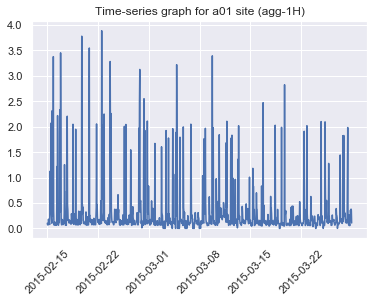

In [178]:
# Plot time series data
f, ax = plt.subplots(1,1)
ax.plot(df_example['ts'])

# Add title
ax.set_title('Time-series graph for a01 site (agg-1H)')

# Rotate x-labels
ax.tick_params(axis = 'x', rotation = 45)

# Show graph
plt.show()
plt.close()

### Testing for stationarity

In [179]:
def test_stationarity(df, ts, win = 12):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    df is the dataframe
    ts is the timestamp column
    win is the window number for calculating the rolling mean ans std
    """
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = win, center = False).mean()
    rolstd = df[ts].rolling(window = win, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

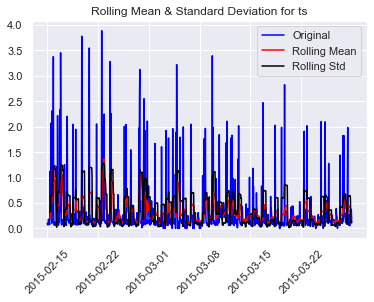

Results of Dickey-Fuller Test:
Test Statistic                -1.288639e+01
p-value                        4.544524e-24
# Lags Used                    6.000000e+00
Number of Observations Used    1.001000e+03
Critical Value (1%)           -3.436900e+00
Critical Value (5%)           -2.864432e+00
Critical Value (10%)          -2.568310e+00
dtype: float64


In [180]:
test_stationarity(df = df_example, ts = 'ts', win = 10)

#### Moving average and other transformation

In [181]:
def plot_transformed_data(df, ts, ts_transform):
  """
  Plot transformed and original time series data
  df is the dataframe
  ts is the timestamp column
  ts_transform is the name of transformed target column
  """
  # Plot time series data
  f, ax = plt.subplots(1,1)
  ax.plot(df[ts])
  ax.plot(df[ts_transform], color = 'red')

  # Add title
  ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

  # Rotate x-labels
  ax.tick_params(axis = 'x', rotation = 45)

  # Add legend
  ax.legend([ts, ts_transform])
  
  plt.show()
  plt.close()
  
  return

C:\Python37\lib\site-packages\pandas\core\algorithms.py:1920: RuntimeWarning:

invalid value encountered in subtract

C:\Python37\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Python37\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ts,ts_log,ts_log_moving_avg,ts_moving_avg,ts_log_diff,ts_moving_avg_diff,ts_log_moving_avg_diff
ds,,,,,,,
2015-02-15 00:00:00,0.101196,-2.290693,NaN,NaN,NaN,NaN,NaN
2015-02-15 01:00:00,0.069214,-2.670554,NaN,NaN,-0.379861,NaN,NaN
2015-02-15 02:00:00,0.070618,-2.650475,NaN,NaN,0.020079,NaN,NaN
2015-02-15 03:00:00,0.068542,-2.680302,NaN,NaN,-0.029827,NaN,NaN
2015-02-15 04:00:00,0.181519,-1.706397,NaN,NaN,0.973904,NaN,NaN


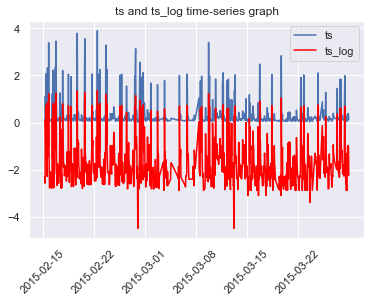

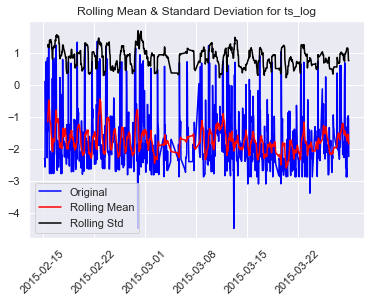

Results of Dickey-Fuller Test:
Test Statistic                -6.244720e+00
p-value                        4.605671e-08
# Lags Used                    2.100000e+01
Number of Observations Used    8.730000e+02
Critical Value (1%)           -3.437863e+00
Critical Value (5%)           -2.864856e+00
Critical Value (10%)          -2.568536e+00
dtype: float64


In [182]:
# Transformation - log ts
df_example['ts_log'] = df_example['ts'].apply(lambda x: np.log(x))

# Transformation - 7-day moving averages of log ts
df_example['ts_log_moving_avg'] = df_example['ts_log'].rolling(window = 7, center = False).mean()

# Transformation - 7-day moving average ts
df_example['ts_moving_avg'] = df_example['ts'].rolling(window = 7, center = False).mean()

# Transformation - Difference between logged ts and first-order difference logged ts
df_example['ts_log_diff'] = df_example['ts_log'] - df_example['ts_log'].shift()
df_example['ts_log_diff'] = df_example['ts_log'].diff()

# Transformation - Difference between ts and moving average ts
df_example['ts_moving_avg_diff'] = df_example['ts'] - df_example['ts_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example['ts_log_moving_avg_diff'] = df_example['ts_log'] - df_example['ts_log_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example_transform = df_example.dropna()

# Transformation - Logged exponentially weighted moving averages (EWMA) ts
df_example_transform['ts_log_ewma'] = df_example_transform['ts_log'].ewm(halflife = 7, ignore_na = False, min_periods = 0, adjust = True).mean()

# Transformation - Difference between logged ts and logged EWMA ts
df_example_transform['ts_log_ewma_diff'] = df_example_transform['ts_log'] - df_example_transform['ts_log_ewma']

# Display data
display(df_example.head())

# Plot data
plot_transformed_data(df = df_example_transform, ts = 'ts', ts_transform = 'ts_log')
#plot_transformed_data(df = df_example_transform, ts = 'ts_log', ts_transform = 'ts_log_moving_avg')
#plot_transformed_data(df = df_example_transform, ts = 'ts', ts_transform = 'ts_moving_avg')
#plot_transformed_data(df = df_example_transform, ts = 'ts_log', ts_transform = 'ts_log_diff')
#plot_transformed_data(df = df_example_transform, ts = 'ts', ts_transform = 'ts_moving_avg_diff')
#plot_transformed_data(df = df_example_transform, ts = 'ts_log', ts_transform = 'ts_log_moving_avg_diff')
#plot_transformed_data(df = df_example_transform, ts = 'ts_log', ts_transform = 'ts_log_ewma')
#plot_transformed_data(df = df_example_transform, ts = 'ts_log', ts_transform = 'ts_log_ewma_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, ts = 'ts_log')
#test_stationarity(df = df_example_transform, ts = 'ts_moving_avg')
#test_stationarity(df = df_example_transform, ts = 'ts_log_moving_avg')
#test_stationarity(df = df_example_transform, ts = 'ts_log_diff')
#test_stationarity(df = df_example_transform, ts = 'ts_moving_avg_diff')
#test_stationarity(df = df_example_transform, ts = 'ts_log_moving_avg_diff')
#test_stationarity(df = df_example_transform, ts = 'ts_log_ewma')
#test_stationarity(df = df_example_transform, ts = 'ts_log_ewma_diff')

#### Decomposition: trend, seasonality, residuals

In [183]:
def plot_decomposition(df, ts, trend, seasonal, residual):
  """
  Plot time series data
  """

  f, ((ax1, ax2, ax3, ax4)) = plt.subplots(4,1, figsize = (8, 10), sharex = True)

  ax1.plot(df[ts], label = 'Original')
  ax1.legend(loc = 'upper right')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend')
  ax2.legend(loc = 'upper right')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality')
  ax3.legend(loc = 'upper right')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals')
  ax4.legend(loc = 'upper right')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  # Show graph
  plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), x = 0.5, y = 1.05, fontsize = 13)
  plt.show()
  plt.close()
  
  return

C:\Python37\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Python37\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



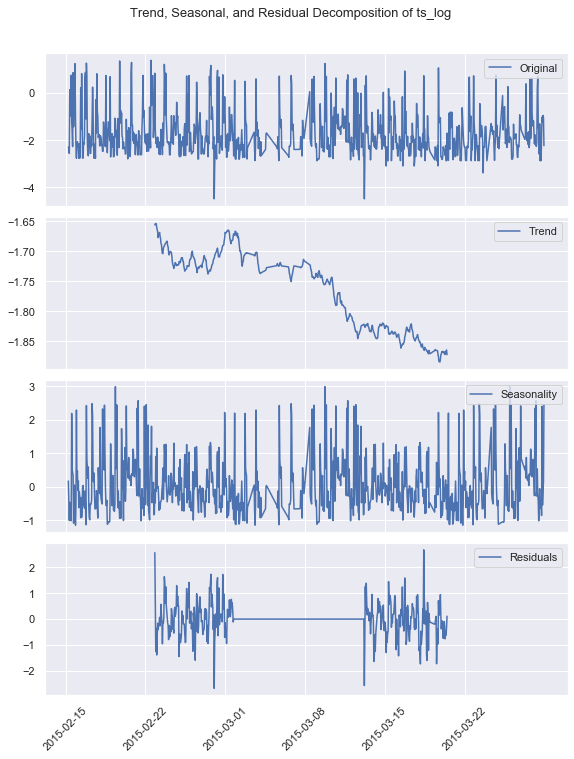

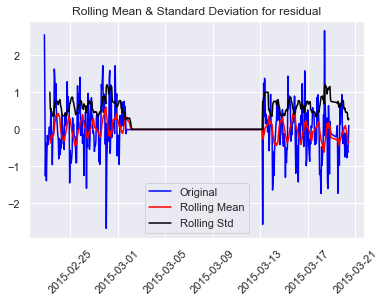

Results of Dickey-Fuller Test:
Test Statistic                -1.001830e+01
p-value                        1.705484e-17
# Lags Used                    1.700000e+01
Number of Observations Used    5.130000e+02
Critical Value (1%)           -3.443162e+00
Critical Value (5%)           -2.867190e+00
Critical Value (10%)          -2.569780e+00
dtype: float64


In [184]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_example_transform['ts_log'], freq = 365)

df_example_transform.loc[:,'trend'] = decomposition.trend
df_example_transform.loc[:,'seasonal'] = decomposition.seasonal
df_example_transform.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = df_example_transform, ts = 'ts_log', trend = 'trend', seasonal = 'seasonal', residual = 'residual')

test_stationarity(df = df_example_transform.dropna(), ts = 'residual')

### ARIMA Models

#### ACF and PACF Plots

In [185]:
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()
  plt.close()
  
  return

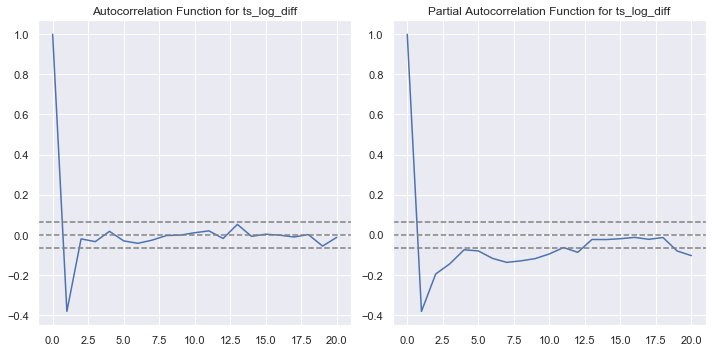

In [186]:
# determine ACF and PACF
lag_acf = acf(np.array(df_example_transform['ts_log_diff']), nlags = 20)
lag_pacf = pacf(np.array(df_example_transform['ts_log_diff']), nlags = 20)

# plot ACF and PACF
plot_acf_pacf(df = df_example_transform, ts = 'ts_log_diff')

#### ARIMA

In [187]:
def run_arima_model(df, ts, p, d, q):
  """
  Run ARIMA model
  p is the number of lags
  """

  # fit ARIMA model on time series
  model = ARIMA(df[ts], order=(p, d, q))  
  results_ = model.fit(disp=-1)  
  
  # get lengths correct to calculate RSS
  len_results = len(results_.fittedvalues)
  ts_modified = df[ts][-len_results:]
  
  # calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df[ts]))
  
  # plot fit
  plt.plot(df[ts])
  plt.plot(results_.fittedvalues, color = 'red')
  plt.title('For ARIMA model (%i, %i, %i) for ts %s, RSS: %.4f, RMSE: %.4f' %(p, d, q, ts, rss, rmse))
  
  plt.show()
  plt.close()
  
  return results_

C:\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



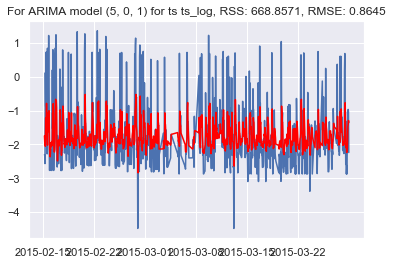

In [188]:
# Note: I do the differencing in the transformation of the data 'ts_log_diff'
# AR model with 1st order differencing - ARIMA (1,0,0)
#model_AR = run_arima_model(df = df_example_transform, ts = 'ts_log_diff', p = 1, d = 0, q = 0)

# MA model with 1st order differencing - ARIMA (0,0,1)
#model_MA = run_arima_model(df = df_example_transform, ts = 'ts_log_diff', p = 0, d = 0, q = 1)

# ARMA model with 1st order differencing - ARIMA (1,0,1)
model_ARMA = run_arima_model(df = df_example_transform, ts = 'ts_log', p = 5, d = 0, q = 1)

### Taking it back to original scale


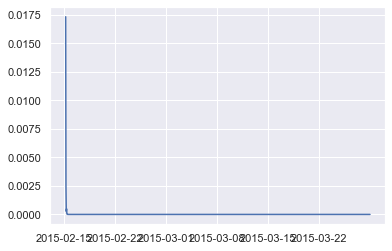

In [190]:
predictions_ARIMA_diff = pd.Series(model_ARMA.fittedvalues, copy=True)
#predictions_ARIMA_diff.head()

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#predictions_ARIMA_diff_cumsum.head()

predictions_ARIMA_log = pd.Series(df_example_transform['ts_log'], index=df_example_transform.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

predictions_ARIMA = np.exp(predictions_ARIMA_log)
#plt.plot(df_example)
plt.plot(predictions_ARIMA)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df_example_transform['ts'])**2)/len(ts)))

### FBProphet

In [ ]:
from fbprophet import Prophet
import datetime
from datetime import datetime

In [41]:
def days_between(d1, d2):
    """Calculate the number of days between two dates.  D1 is start date (inclusive) and d2 is end date (inclusive)"""
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days + 1)

In [42]:
# Inputs for query

date_column = 'dt'
metric_column = 'ts'
table = df_example
start_training_date = '2010-07-03'
end_training_date = '2018-09-08'
start_forecasting_date = '2018-09-09'
end_forecasting_date = '2018-12-31'
year_to_estimate = '2018'

# Inputs for forecasting

# future_num_points
# If doing different time intervals, change future_num_points
future_num_points = days_between(start_forecasting_date, end_forecasting_date)

cap = None # 2e6

# growth: default = 'linear'
# Can also choose 'logistic'
growth = 'linear'

# n_changepoints: default = 25, uniformly placed in first 80% of time series
n_changepoints = 25 

# changepoint_prior_scale: default = 0.05
# Increasing it will make the trend more flexible
changepoint_prior_scale = 0.05 

# changpoints: example = ['2016-01-01']
changepoints = None 

# holidays_prior_scale: default = 10
# If you find that the holidays are overfitting, you can adjust their prior scale to smooth them
holidays_prior_scale = 10 

# interval_width: default = 0.8
interval_width = 0.8 

# mcmc_samples: default = 0
# By default Prophet will only return uncertainty in the trend and observation noise.
# To get uncertainty in seasonality, you must do full Bayesian sampling. 
# Replaces typical MAP estimation with MCMC sampling, and takes MUCH LONGER - e.g., 10 minutes instead of 10 seconds.
# If you do full sampling, then you will see the uncertainty in seasonal components when you plot:
mcmc_samples = 0

# holiday: default = None
# thanksgiving = pd.DataFrame({
#   'holiday': 'thanksgiving',
#   'ds': pd.to_datetime(['2014-11-27', '2015-11-26',
#                         '2016-11-24', '2017-11-23']),
#   'lower_window': 0,
#   'upper_window': 4,
# })
# christmas = pd.DataFrame({
#   'holiday': 'christmas',
#   'ds': pd.to_datetime(['2014-12-25', '2015-12-25', 
#                         '2016-12-25','2017-12-25']),
#   'lower_window': -1,
#   'upper_window': 0,
# })
# holidays = pd.concat((thanksgiving,christmas))
holidays = None

daily_seasonality = True

NameError: name 'datetime' is not defined

In [ ]:
# get relevant data - note: could also try this with ts_log_diff
df_prophet = df_example_transform[['ts']] # can try with ts_log_diff

# reset index
df_prophet = df_prophet.reset_index()

# rename columns
df_prophet = df_prophet.rename(columns = {'ds': 'ds', 'ts': 'y'}) # can try with ts_log_diff

# Change 'ds' type from datetime to date (necessary for FB Prophet)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Change 'y' type to numeric (necessary for FB Prophet)
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='ignore')

# Remove any outliers
# df.loc[(df_['ds'] > '2016-12-13') & (df_['ds'] < '2016-12-19'), 'y'] = None

In [ ]:
def create_daily_forecast(df,
#                           cap,
                          holidays,
                          growth,
                          n_changepoints = 25,
                          changepoint_prior_scale = 0.05,
                          changepoints = None,
                          holidays_prior_scale = 10,
                          interval_width = 0.8,
                          mcmc_samples = 1,
                          future_num_points = 10, 
                          daily_seasonality = True):
  """
  Create forecast
  """
  
  # Create copy of dataframe
  df_ = df.copy()

  # Add in growth parameter, which can change over time
  #     df_['cap'] = max(df_['y']) if cap is None else cap

  # Create model object and fit to dataframe
  m = Prophet(growth = growth,
              n_changepoints = n_changepoints,
              changepoint_prior_scale = changepoint_prior_scale,
              changepoints = changepoints,
              holidays = holidays,
              holidays_prior_scale = holidays_prior_scale,
              interval_width = interval_width,
              mcmc_samples = mcmc_samples, 
              daily_seasonality = daily_seasonality)

  # Fit model with dataframe
  m.fit(df_)

  # Create dataframe for predictions
  future = m.make_future_dataframe(periods = future_num_points)
  #     future['cap'] = max(df_['y']) if cap is None else cap

  # Create predictions
  fcst = m.predict(future)

  # Plot
  m.plot(fcst);
  m.plot_components(fcst)

  return fcst

In [ ]:
fcst = create_daily_forecast(df_prophet,
#                              cap,
                             holidays,
                             growth,
                             n_changepoints,
                             changepoint_prior_scale,
                             changepoints, 
                             holidays_prior_scale,
                             interval_width,
                             mcmc_samples,
                             future_num_points, 
                             daily_seasonality)

## LGBM (Gradient Boosting Decision Tree)

In [70]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'bagging_freq': 5,
            'num_leaves': 330,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 10
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

models = []

for train_index,test_index in kf.split(train_df[feat_cols]):
    train_features = train_df[feat_cols].loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = train_df[feat_cols].loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target, categorical_feature=categorical_feat, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target, categorical_feature=categorical_feat, free_raw_data=False)
    
    model = lgb.train(params,
                      train_set=d_training,
                      num_boost_round=1000,
                      valid_sets=[d_training,d_test],
                      verbose_eval=25,
                      early_stopping_rounds=50)
    
    models.append(model)
    
    del train_features, train_target, test_features, test_target, d_training, d_test
    
    gc.collect()

C:\Python37\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.221332	valid_1's rmse: 0.312978
[50]	training's rmse: 0.220789	valid_1's rmse: 0.31313
Early stopping, best iteration is:
[3]	training's rmse: 0.248183	valid_1's rmse: 0.292581
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.221022	valid_1's rmse: 0.324917
[50]	training's rmse: 0.220438	valid_1's rmse: 0.325278
Early stopping, best iteration is:
[3]	training's rmse: 0.247521	valid_1's rmse: 0.302291
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.215176	valid_1's rmse: 0.365689
[50]	training's rmse: 0.214549	valid_1's rmse: 0.36627
Early stopping, best iteration is:
[14]	training's rmse: 0.218209	valid_1's rmse: 0.364028
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.21457	valid_1's rmse: 0.299848
[50]	training's rmse: 0.213956	valid_1's rmse: 0.300257
Early stopping, best iteration is:
[7]	t

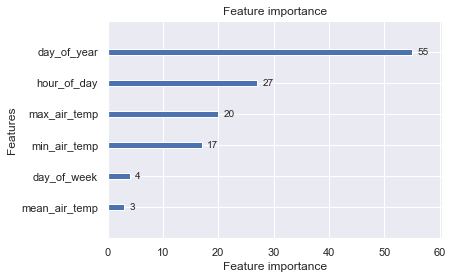

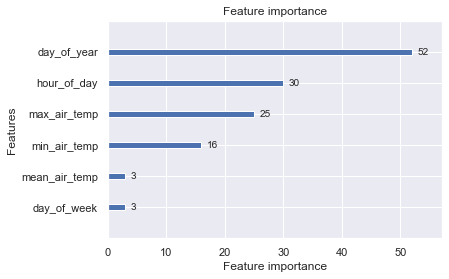

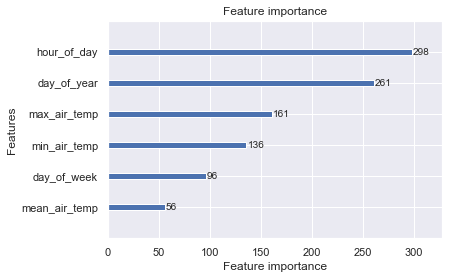

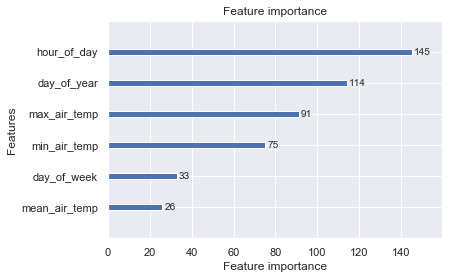

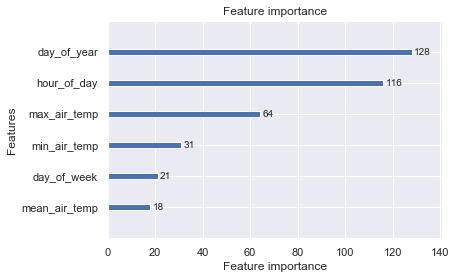

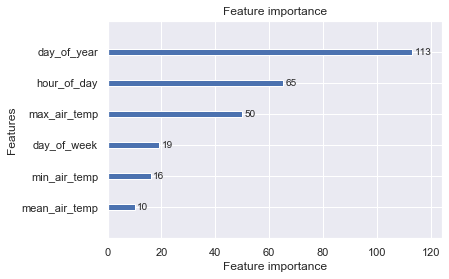

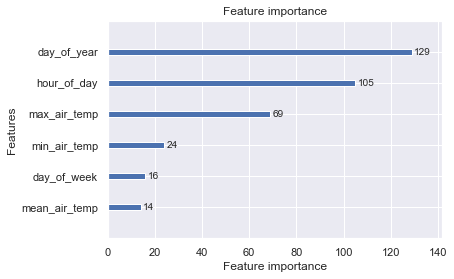

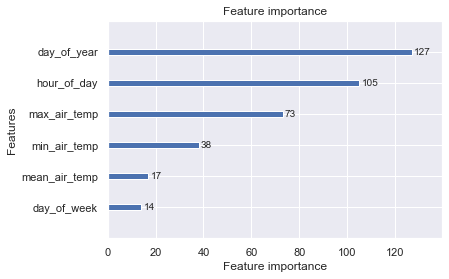

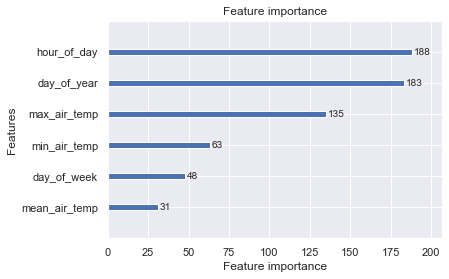

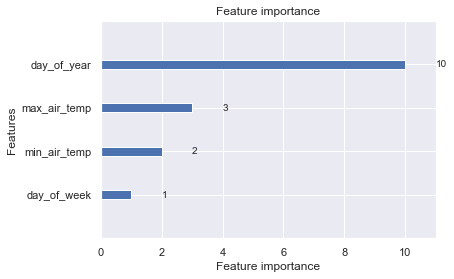

In [71]:
# feature Importance# 
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [72]:
test_df = test_df.drop(drop_cols, axis = 1)
testtarget = test_df['meter_reading']
test_df = test_df.drop('meter_reading', axis = 1)

In [73]:
#prediction
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

In [74]:
compare = pd.DataFrame(results, columns=['lgbm_pred'])
compare = compare.join(test_val, how='left')
compare = compare.drop(['month', 'week_of_year', 'day_of_year', 'hour_of_day', 'day_of_week', 'day_of_month', 'week_of_month', 'bank_holiday', 'max_air_temp', 'min_air_temp', 'mean_air_temp'] , axis = 1)
compare['meter_loglp'] = np.log1p(testtarget)
compare['dif_lgbm'] = compare['meter_loglp'] - compare['lgbm_pred']
compare.head()

,lgbm_pred,meter_reading,time,site_id,meter_loglp,dif_lgbm
0,0.251904,0.213013,2015-03-20 14:25:00,1,0.193107,-0.058797
1,0.251904,0.338867,2015-03-20 14:30:00,1,0.291824,0.039920
2,0.251904,1.65234,2015-03-20 14:35:00,1,0.975444,0.723539
3,0.251904,0.198242,2015-03-20 14:40:00,1,0.180856,-0.071049
4,0.251904,0.155273,2015-03-20 14:45:00,1,0.144337,-0.107567


## Deep Neural Netwoork

### Keras Imports

In [76]:
# use for imputining data points with mean.

def average_imputation(df, column_name):
    imputation = df.groupby(['timestamp'])[column_name].mean()
    
    df.loc[df[column_name].isnull(), column_name] = df[df[column_name].isnull()][[column_name]].apply(lambda x: imputation[df['timestamp'][x.index]].values)
    del imputation
    return df

In [77]:
# changing wind speed to beaufort scale
def to_beaufort(df, column):
    beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
                (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]
    for item in beaufort:
        train.loc[(train['wind_speed']>=item[1]) & (train['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

### Building the model

In [54]:
def model(dense_dim_1=64, dense_dim_2=32, dense_dim_3=32, dense_dim_4=16, 
dropout1=0.2, dropout2=0.1, dropout3=0.1, dropout4=0.1, lr=0.001):

    #Inputs
    site_id = Input(shape=[1], name="site_id")
    day_of_year = Input(shape=[1], name="day_of_year")
    hour_of_day = Input(shape=[1], name="hour_of_day")
    day_of_week = Input(shape=[1], name="day_of_week")
    max_air_temp = Input(shape=[1], name="max_air_temp")
    min_air_temp = Input(shape=[1], name="min_air_temp")
    mean_air_temp = Input(shape=[1], name="mean_air_temp")
   
    #Embeddings layers
    emb_site_id = Embedding(16, 2)(site_id)
    emb_day_of_year = Embedding(365, 2)(day_of_year)
    emb_hour_of_day = Embedding(24, 3)(hour_of_day)
    emb_day_of_week = Embedding(7, 2)(day_of_week)

    concat_emb = concatenate([Flatten() (emb_site_id), Flatten() (emb_day_of_year), Flatten() (emb_hour_of_day), Flatten() (emb_day_of_week)])
    
    categ = Dropout(dropout1)(Dense(dense_dim_1,activation='relu') (concat_emb))
    categ = BatchNormalization()(categ)
    categ = Dropout(dropout2)(Dense(dense_dim_2,activation='relu') (categ))
    
    #main layer
    main_l = concatenate([categ, max_air_temp, min_air_temp, mean_air_temp])
    main_l = Dropout(dropout3)(Dense(dense_dim_3,activation='relu') (main_l))
    main_l = BatchNormalization()(main_l)
    main_l = Dropout(dropout4)(Dense(dense_dim_4,activation='relu') (main_l))
    
    #output
    output = Dense(1) (main_l)
    
    model = Model([site_id, day_of_year, hour_of_day, day_of_week, max_air_temp, min_air_temp, mean_air_temp], output)

    model.compile(optimizer=Adam(lr=lr), loss= mse_loss, metrics=[root_mean_squared_error])
    
    return model

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))

### Training the model

In [79]:
def get_keras_data(df, num_cols, cat_cols):
    cols = num_cols + cat_cols
    X = {col: np.array(df[col]) for col in cols}
    return X

def train_model(keras_model, X_t, y_train, batch_size, epochs, X_v, y_valid, fold, patience=3):
    early_stopping = EarlyStopping(patience=patience, verbose=1)
    model_checkpoint = ModelCheckpoint("model_" + str(fold) + ".hdf5",
                                       save_best_only=True, verbose=1, monitor='val_root_mean_squared_error', mode='min')

    hist = keras_model.fit(X_t, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(X_v, y_valid), verbose=1,
                            callbacks=[early_stopping, model_checkpoint])

    keras_model = load_model("model_" + str(fold) + ".hdf5", custom_objects={'root_mean_squared_error': root_mean_squared_error})
    
    return keras_model

### Testing the model

In [80]:
from sklearn.model_selection import KFold, StratifiedKFold

oof = np.zeros(len(train_df))
batch_size = 1024
epochs = 10
models = []

folds = 5
seed = 666

kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

for fold_n, (train_index, valid_index) in enumerate(kf.split(train_df, train_df['site_id'])):
    print('Fold:', fold_n)
    X_train, X_valid = train_df.iloc[train_index], train_df.iloc[valid_index]
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_t = get_keras_data(X_train, numericals, categorical_feat)
    X_v = get_keras_data(X_valid, numericals, categorical_feat)
    
    keras_model = model(dense_dim_1=64, dense_dim_2=32, dense_dim_3=32, dense_dim_4=16, 
                        dropout1=0.2, dropout2=0.1, dropout3=0.1, dropout4=0.1, lr=0.01)
    mod = train_model(keras_model, X_t, y_train, batch_size, epochs, X_v, y_valid, fold_n, patience=3)
    models.append(mod)
    print('*'* 50)

Fold: 0


C:\pypy\deep_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 7741 samples, validate on 1936 samples
Epoch 1/10
7741/7741 [==============================] - 1s 86us/step - loss: 0.4614 - root_mean_squared_error: 0.6426 - val_loss: 0.3814 - val_root_mean_squared_error: 0.6154

Epoch 00001: val_root_mean_squared_error improved from inf to 0.61541, saving model to model_0.hdf5
Epoch 2/10
7741/7741 [==============================] - 0s 6us/step - loss: 0.1614 - root_mean_squared_error: 0.3993 - val_loss: 0.4498 - val_root_mean_squared_error: 0.6675

Epoch 00002: val_root_mean_squared_error did not improve from 0.61541
Epoch 3/10
7741/7741 [==============================] - 0s 6us/step - loss: 0.1154 - root_mean_squared_error: 0.3373 - val_loss: 0.1135 - val_root_mean_squared_error: 0.3353

Epoch 00003: val_root_mean_squared_error improved from 0.61541 to 0.33526, saving model to model_0.hdf5
Epoch 4/10
7741/7741 [==============================] - 0s 6us/step - loss: 0.0989 - root_mean_squared_error: 0.3125 - val_loss: 0.1033 - val_root_mean_

C:\pypy\deep_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



**************************************************
Fold: 1


C:\pypy\deep_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 7741 samples, validate on 1936 samples
Epoch 1/10
7741/7741 [==============================] - 1s 94us/step - loss: 0.3059 - root_mean_squared_error: 0.5363 - val_loss: 0.2434 - val_root_mean_squared_error: 0.4910

Epoch 00001: val_root_mean_squared_error improved from inf to 0.49104, saving model to model_1.hdf5
Epoch 2/10
7741/7741 [==============================] - 0s 7us/step - loss: 0.1351 - root_mean_squared_error: 0.3664 - val_loss: 0.0937 - val_root_mean_squared_error: 0.3038

Epoch 00002: val_root_mean_squared_error improved from 0.49104 to 0.30384, saving model to model_1.hdf5
Epoch 3/10
7741/7741 [==============================] - 0s 7us/step - loss: 0.0990 - root_mean_squared_error: 0.3124 - val_loss: 0.0885 - val_root_mean_squared_error: 0.2904

Epoch 00003: val_root_mean_squared_error improved from 0.30384 to 0.29043, saving model to model_1.hdf5
Epoch 4/10
7741/7741 [==============================] - 0s 6us/step - loss: 0.0831 - root_mean_squared_error: 0.2873 -

C:\pypy\deep_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



**************************************************
Fold: 2


C:\pypy\deep_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 7742 samples, validate on 1935 samples
Epoch 1/10
7742/7742 [==============================] - 1s 85us/step - loss: 0.3910 - root_mean_squared_error: 0.5860 - val_loss: 0.2260 - val_root_mean_squared_error: 0.4762

Epoch 00001: val_root_mean_squared_error improved from inf to 0.47616, saving model to model_2.hdf5
Epoch 2/10
7742/7742 [==============================] - 0s 7us/step - loss: 0.1462 - root_mean_squared_error: 0.3809 - val_loss: 0.0821 - val_root_mean_squared_error: 0.2867

Epoch 00002: val_root_mean_squared_error improved from 0.47616 to 0.28668, saving model to model_2.hdf5
Epoch 3/10
7742/7742 [==============================] - 0s 6us/step - loss: 0.1091 - root_mean_squared_error: 0.3280 - val_loss: 0.0982 - val_root_mean_squared_error: 0.3135

Epoch 00003: val_root_mean_squared_error did not improve from 0.28668
Epoch 4/10
7742/7742 [==============================] - 0s 7us/step - loss: 0.0940 - root_mean_squared_error: 0.3065 - val_loss: 0.0750 - val_root_mean_

C:\pypy\deep_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



**************************************************
Fold: 3


C:\pypy\deep_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 7742 samples, validate on 1935 samples
Epoch 1/10
7742/7742 [==============================] - 1s 90us/step - loss: 0.6473 - root_mean_squared_error: 0.7486 - val_loss: 0.1966 - val_root_mean_squared_error: 0.4401

Epoch 00001: val_root_mean_squared_error improved from inf to 0.44007, saving model to model_3.hdf5
Epoch 2/10
7742/7742 [==============================] - 0s 7us/step - loss: 0.1692 - root_mean_squared_error: 0.4043 - val_loss: 0.3771 - val_root_mean_squared_error: 0.6114

Epoch 00002: val_root_mean_squared_error did not improve from 0.44007
Epoch 3/10
7742/7742 [==============================] - 0s 7us/step - loss: 0.1037 - root_mean_squared_error: 0.3210 - val_loss: 0.1324 - val_root_mean_squared_error: 0.3639

Epoch 00003: val_root_mean_squared_error improved from 0.44007 to 0.36388, saving model to model_3.hdf5
Epoch 4/10
7742/7742 [==============================] - 0s 7us/step - loss: 0.0844 - root_mean_squared_error: 0.2893 - val_loss: 0.0863 - val_root_mean_

C:\pypy\deep_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



**************************************************
Fold: 4


C:\pypy\deep_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 7742 samples, validate on 1935 samples
Epoch 1/10
7742/7742 [==============================] - 1s 76us/step - loss: 0.3040 - root_mean_squared_error: 0.5302 - val_loss: 0.1002 - val_root_mean_squared_error: 0.3091

Epoch 00001: val_root_mean_squared_error improved from inf to 0.30911, saving model to model_4.hdf5
Epoch 2/10
7742/7742 [==============================] - 0s 6us/step - loss: 0.1186 - root_mean_squared_error: 0.3431 - val_loss: 0.0871 - val_root_mean_squared_error: 0.2884

Epoch 00002: val_root_mean_squared_error improved from 0.30911 to 0.28837, saving model to model_4.hdf5
Epoch 3/10
7742/7742 [==============================] - 0s 6us/step - loss: 0.0896 - root_mean_squared_error: 0.2992 - val_loss: 0.0831 - val_root_mean_squared_error: 0.2826

Epoch 00003: val_root_mean_squared_error improved from 0.28837 to 0.28262, saving model to model_4.hdf5
Epoch 4/10
7742/7742 [==============================] - 0s 7us/step - loss: 0.0813 - root_mean_squared_error: 0.2847 -

C:\pypy\deep_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



**************************************************


In [81]:
from tqdm import tqdm
i=0
res = np.zeros((test_df.shape[0]),dtype=np.float32)
step_size = 50000
for j in tqdm(range(int(np.ceil(test_df.shape[0]/step_size)))):
    for_prediction = get_keras_data(test_df.iloc[i:i+step_size], numericals, categorical_feat)
    res[i:min(i+step_size,test_df.shape[0])] = \
       np.expm1(sum([model.predict(for_prediction, batch_size=1024)[:,0] for model in models])/folds)
    i+=step_size

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


In [84]:
compare['NN_pred'] = res
compare.loc[compare['meter_reading']<0, 'meter_reading'] = 0
compare['dif_NN'] = compare['meter_reading'] - compare['NN_pred']
compare.to_csv('csv/compre_result.csv', index=False)
compare.head()

,lgbm_pred,meter_reading,time,site_id,meter_loglp,dif_lgbm,NN_pred,dif_NN
0,0.251904,0.213013,2015-03-20 14:25:00,1,0.193107,-0.058797,0.193416,0.0195964
1,0.251904,0.338867,2015-03-20 14:30:00,1,0.291824,0.039920,0.193416,0.145451
2,0.251904,1.65234,2015-03-20 14:35:00,1,0.975444,0.723539,0.193416,1.45893
3,0.251904,0.198242,2015-03-20 14:40:00,1,0.180856,-0.071049,0.193416,0.00482593
4,0.251904,0.155273,2015-03-20 14:45:00,1,0.144337,-0.107567,0.193416,-0.0381428


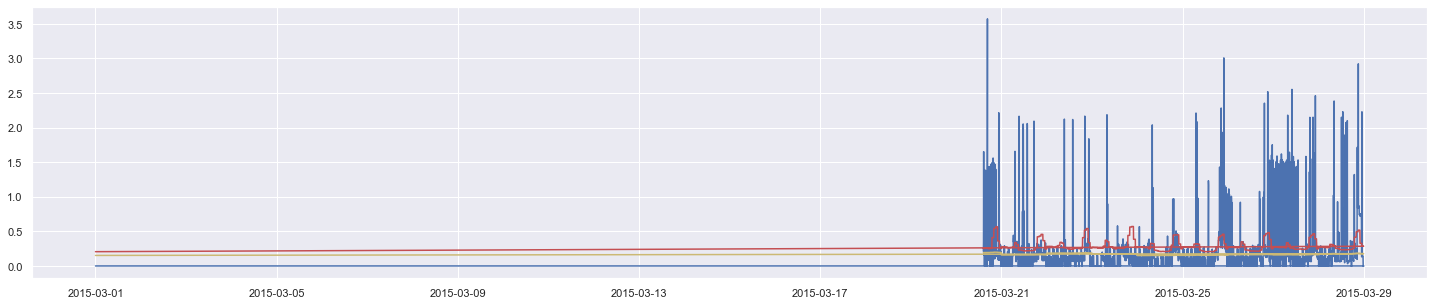

In [85]:
plt.figure(figsize=(25,5))
plt.plot(compare['time'], compare['meter_reading'])
plt.plot(compare['time'], compare['lgbm_pred'], color='r')
plt.plot(compare['time'], compare['NN_pred'], color='y')
plt.show()

## LSTM

In [191]:
lstm_df = df_example.drop(labels=['ts_log', 'ts_log_moving_avg', 'ts_moving_avg', 'ts_log_diff', 'ts_moving_avg_diff', 'ts_log_moving_avg_diff'], axis=1)
lstm_df

,ts
ds,
2015-02-15 00:00:00,0.101196
2015-02-15 01:00:00,0.069214
2015-02-15 02:00:00,0.070618
2015-02-15 03:00:00,0.068542
2015-02-15 04:00:00,0.181519
...,...
2015-03-28 19:00:00,0.356201
2015-03-28 20:00:00,0.290039
2015-03-28 21:00:00,0.379639


In [195]:
def do_lstm_model(df, ts, look_back, epochs, type_ = None, train_fraction = 0.80):
  """
   Create LSTM model
  """

  # Convert an array of values into a dataset matrix
  def create_dataset(dataset, look_back=1):
    """
    Create the dataset
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back), 0]
      dataX.append(a)
      dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

  # Get dataset
  dataset = df[ts].values
  dataset = dataset.astype('float32')

  # Normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset.reshape(-1, 1))
  
  # Split into train and test sets
  train_size = int(len(dataset) * train_fraction)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
  # Reshape into X=t and Y=t+1
  look_back = look_back
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)
  
  # Reshape input to be [samples, time steps, features]
  if type_ == 'regression with time steps':
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
  elif type_ == 'stacked with memory between batches':
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
  else:
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  
  # Create and fit the LSTM network
  batch_size = 1
  model = Sequential()
  
  if type_ == 'regression with time steps':
    model.add(LSTM(6, input_shape=(look_back, 1)))
  elif type_ == 'memory between batches':
    model.add(LSTM(6, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  elif type_ == 'stacked with memory between batches':
    model.add(LSTM(6, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(8, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  else:
    model.add(LSTM(6, input_shape=(1, look_back)))
  
  model.add(Dense(1, activation='relu'))
  model.compile(loss='mean_squared_error', optimizer='sgd')

  if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
    for i in range(100):
      model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
      model.reset_states()
  else:
    model.fit(trainX, 
              trainY, 
              epochs = epochs, 
              batch_size = 1, 
              verbose = 2)
  
  # Make predictions
  if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
    trainPredict = model.predict(trainX, batch_size=batch_size)
    testPredict = model.predict(testX, batch_size=batch_size)
  else:
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
  
  # Invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  
  # Calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  
  # Shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  
  # Shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
  
  model.summary()
    
  # Plot baseline and predictions
  plt.plot(scaler.inverse_transform(dataset))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.show()
  plt.close()
  
  return

Epoch 1/10
 - 1s - loss: 0.0228
Epoch 2/10
 - 1s - loss: 0.0228
Epoch 3/10
 - 1s - loss: 0.0225
Epoch 4/10
 - 1s - loss: 0.0227
Epoch 5/10
 - 1s - loss: 0.0224
Epoch 6/10
 - 1s - loss: 0.0224
Epoch 7/10
 - 1s - loss: 0.0223
Epoch 8/10
 - 1s - loss: 0.0224
Epoch 9/10
 - 1s - loss: 0.0223
Epoch 10/10
 - 1s - loss: 0.0223
Train Score: 0.58 RMSE
Test Score: 0.41 RMSE
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 6)                 408       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 7         
Total params: 415
Trainable params: 415
Non-trainable params: 0
_________________________________________________________________


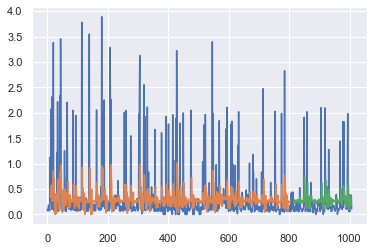

It takes  0.15  Min to train and test the model


In [200]:
import time
tic = time.clock()

# LSTM Network for Regression
do_lstm_model(df = df_example, ts = 'ts', look_back = 10, epochs = 10)

# LSTM for Regression Using the Window Method
#do_lstm_model(df = df_example, ts = 'ts', look_back = 10, epochs = 10)

# LSTM for Regression with Time Steps
#do_lstm_model(df = df_example, ts = 'ts', look_back = 3, epochs = 5, type_ = 'regression with time steps')

# LSTM with Memory Between Batches
#do_lstm_model(df = df_example, ts = 'ts', look_back = 3, epochs = 5, type_ = 'memory between batches')

# Stacked LSTMs with Memory Between Batches
#do_lstm_model(df = df_example, ts = 'ts', look_back = 30, epochs = 10, type_ = 'stacked with memory between batches')

toc = time.clock()
timeit = (toc - tic)/60
print('It takes ',str(round(timeit, 2)),' Min to train and test the model')

## Random Forest regressor